<a href="https://colab.research.google.com/github/zeitgeistnirvana/Heston_Model/blob/main/SilverBollingerBandsMovingAverageAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip uninstall -y polygon
!pip install polygon-api-client
import pandas as pd
import numpy as np
from polygon.rest import RESTClient
from datetime import datetime, timedelta

class SilverHybridTrader:
    def __init__(self, api_key=None):  # Pass API key if not configured
        # IMPORTANT: Replace 'YOUR_POLYGON_API_KEY' with your actual Polygon.io API key
        # Alternatively, set an environment variable named POLYGON_API_KEY
        self.client = RESTClient(api_key if api_key else 'YOUR_POLYGON_API_KEY')  # Use env var or pass key
        self.ticker = "C:XAGUSD"
        self.swing_bias = 0  # 1: long, -1: short, 0: flat

    def fetch_data(self, timespan, multiplier=1, from_date=None, to_date=None, limit=50000):
        if not from_date:
            from_date = (datetime.now() - timedelta(days=365)).strftime("%Y-%m-%d")
        if not to_date:
            to_date = datetime.now().strftime("%Y-%m-%d")
        aggs = self.client.get_aggs(self.ticker, multiplier, timespan, from_date, to_date, limit=limit)
        df = pd.DataFrame(aggs)
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        return df

    def compute_sma_crossover(self, df_daily):
        df_daily['SMA50'] = df_daily['close'].rolling(window=50).mean()
        df_daily['SMA200'] = df_daily['close'].rolling(window=200).mean()
        df_daily['signal'] = 0
        df_daily['signal'][50:] = np.where(df_daily['SMA50'][50:] > df_daily['SMA200'][50:], 1, -1)
        self.swing_bias = df_daily['signal'][-1]  # Latest bias

    def compute_macd(self, series, fast=12, slow=26, sig=9):
        ema_fast = series.ewm(span=fast, adjust=False).mean()
        ema_slow = series.ewm(span=slow, adjust=False).mean()
        macd_line = ema_fast - ema_slow
        signal_line = macd_line.ewm(span=sig, adjust=False).mean()
        return macd_line, signal_line

    def generate_intraday_signals(self, df_intraday):
        df_intraday['macd'], df_intraday['signal_line'] = self.compute_macd(df_intraday['close'])
        df_intraday['prev_macd'] = df_intraday['macd'].shift(1)
        df_intraday['prev_signal'] = df_intraday['signal_line'].shift(1)

        # Buy if crossover up and swing long bias
        df_intraday['buy'] = ((df_intraday['prev_macd'] < df_intraday['prev_signal']) &
                              (df_intraday['macd'] > df_intraday['signal_line']) &
                              (self.swing_bias == 1)).astype(int)

        # Sell if crossover down and swing short bias (or as exit for longs)
        df_intraday['sell'] = ((df_intraday['prev_macd'] > df_intraday['prev_signal']) &
                               (df_intraday['macd'] < df_intraday['signal_line']) &
                               (self.swing_bias == -1)).astype(int)  # Adjust for exits

        return df_intraday[df_intraday['buy'] == 1 | df_intraday['sell'] == 1]

    def run(self, capital=10000, risk_per_trade=0.01):
        # Step 1: Get daily for swing
        df_daily = self.fetch_data("day")
        self.compute_sma_crossover(df_daily)

        if self.swing_bias == 0:
            print("No clear bias - flat.")
            return

        # Step 2: Get today's intraday
        today = datetime.now().strftime("%Y-%m-%d")
        df_intraday = self.fetch_data("minute", from_date=today, to_date=today)

        # Step 3: Signals
        signals = self.generate_intraday_signals(df_intraday)

        # Simulate trades (example)
        position = 0
        entry_price = 0
        for idx, row in signals.iterrows():
            if row['buy'] and position == 0:
                position_size = (capital * risk_per_trade) / 0.005  # Based on 0.5% SL
                position = position_size / row['close']  # Units
                entry_price = row['close']
                sl = entry_price * 0.995
                tp = entry_price * 1.01
                print(f"Buy at {idx}: {entry_price}")

            elif row['sell'] and position > 0:
                exit_price = row['close']
                pnl = position * (exit_price - entry_price)
                capital += pnl
                position = 0
                print(f"Sell at {idx}: {exit_price}, PnL: {pnl}")

        print(f"Final capital: {capital}")

# Usage
trader = SilverHybridTrader()  # Assumes API key set
trader.run()

BadResponse: {"status":"ERROR","request_id":"cb5936372712e7d57aa0aa8202ba64c7","error":"Unknown API Key"}

You can access Google Finance through your web browser at `https://www.google.com/finance` to view stock prices, charts, and news. There isn't a direct, officially supported Python API for Google Finance that would allow programmatic data retrieval in the same way as Polygon.io.

If you need to fetch financial data programmatically, you might consider alternatives like:

*   **`yfinance` library**: A popular open-source library that allows you to download historical market data from Yahoo Finance.
*   **Alpha Vantage API**: Offers a free tier for developers with various financial data APIs.
*   **Other commercial data providers**: Many services offer APIs for financial data, often with free trials or limited free tiers.

In [5]:
# If you decide to use a different library to fetch financial data (e.g., yfinance), you can write your code here.

import yfinance as yf
ticker_data = yf.Ticker("SI=F") # Changed ticker to silver futures for more accurate pricing
historical_prices = ticker_data.history(period="1y")
display(historical_prices.head())

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-01-06 00:00:00-05:00,30.370001,30.459999,29.959999,30.341999,186,0.0,0.0
2025-01-07 00:00:00-05:00,30.447001,30.447001,30.447001,30.447001,6,0.0,0.0
2025-01-08 00:00:00-05:00,30.525000,30.650000,30.280001,30.452000,46,0.0,0.0
2025-01-09 00:00:00-05:00,30.965000,30.965000,30.735001,30.791000,192,0.0,0.0
2025-01-10 00:00:00-05:00,31.535000,31.535000,31.090000,31.091000,60,0.0,0.0


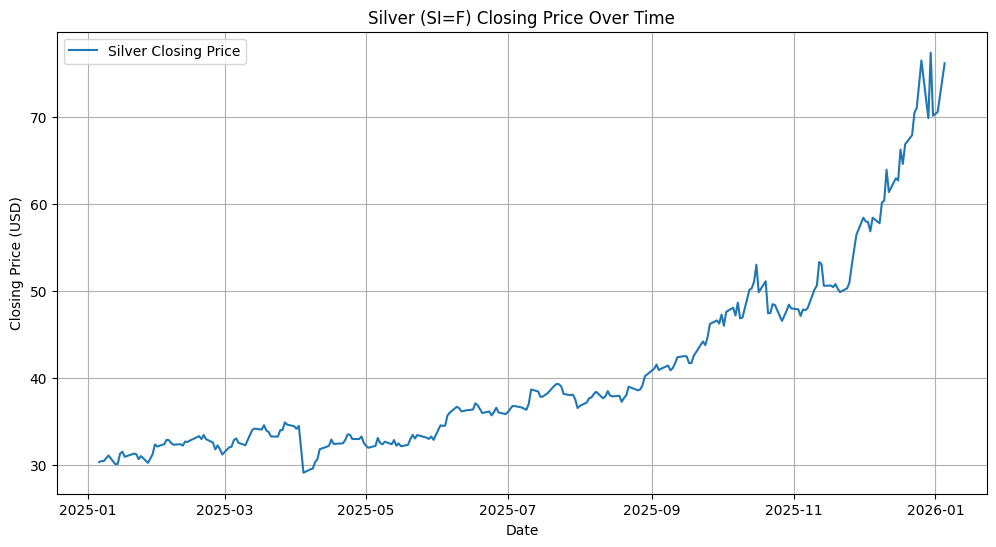

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(historical_prices.index, historical_prices['Close'], label='Silver Closing Price')
plt.title('Silver (SI=F) Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.grid(True)
plt.legend()
plt.show()

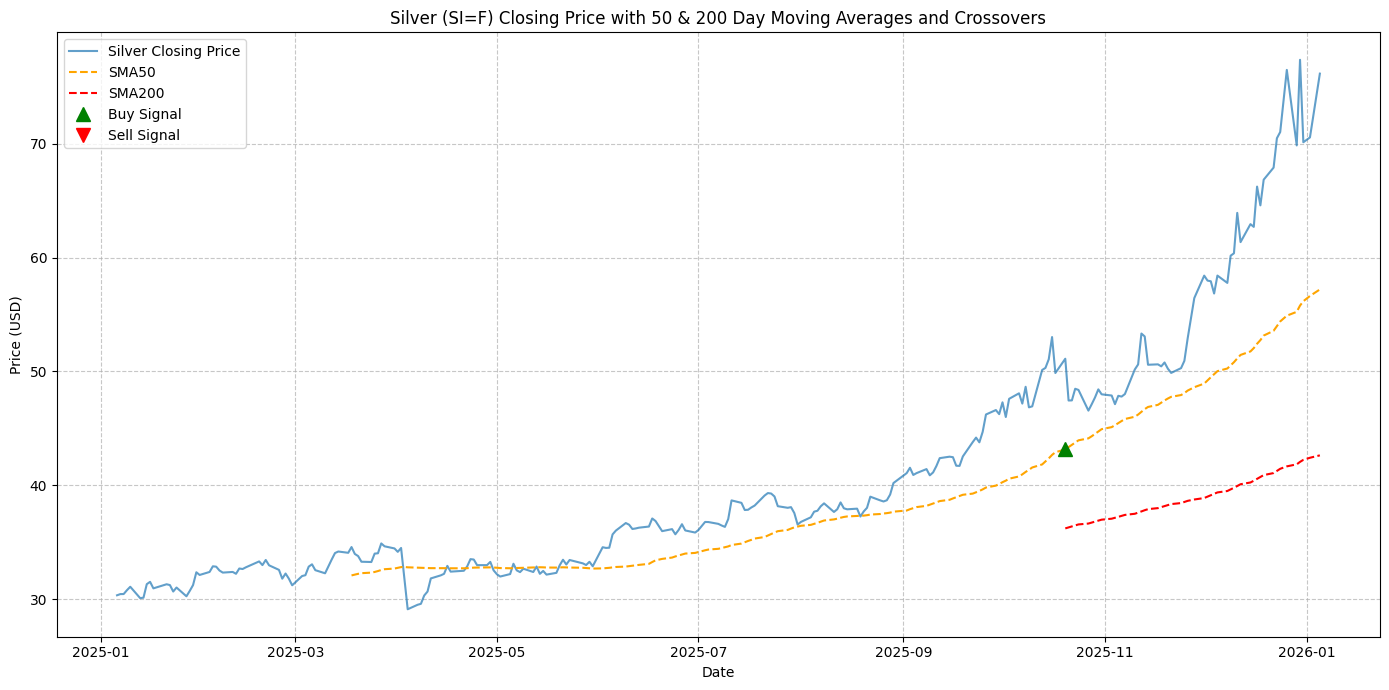

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate 50-day and 200-day Simple Moving Averages
historical_prices['SMA50'] = historical_prices['Close'].rolling(window=50).mean()
historical_prices['SMA200'] = historical_prices['Close'].rolling(window=200).mean()

# Generate signals for crossovers
# Create a 'signal' column. 1 if SMA50 > SMA200, -1 if SMA50 < SMA200
historical_prices.loc[historical_prices.index[50:], 'Signal'] = np.where(historical_prices['SMA50'][50:] > historical_prices['SMA200'][50:], 1, -1)

# Identify crossover points
historical_prices['Position'] = historical_prices['Signal'].diff()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(historical_prices.index, historical_prices['Close'], label='Silver Closing Price', alpha=0.7)
plt.plot(historical_prices.index, historical_prices['SMA50'], label='SMA50', color='orange', linestyle='--')
plt.plot(historical_prices.index, historical_prices['SMA200'], label='SMA200', color='red', linestyle='--')

# Plot buy signals (golden cross: SMA50 crosses above SMA200)
plt.plot(historical_prices[historical_prices['Position'] == 2].index,
         historical_prices['SMA50'][historical_prices['Position'] == 2],
         '^', markersize=10, color='green', lw=0, label='Buy Signal')

# Plot sell signals (death cross: SMA50 crosses below SMA200)
plt.plot(historical_prices[historical_prices['Position'] == -2].index,
         historical_prices['SMA50'][historical_prices['Position'] == -2],
         'v', markersize=10, color='red', lw=0, label='Sell Signal')

plt.title('Silver (SI=F) Closing Price with 50 & 200 Day Moving Averages and Crossovers')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Combined Buy Signal Dates (MA Golden Cross + Price at/below Lower Bollinger Band):


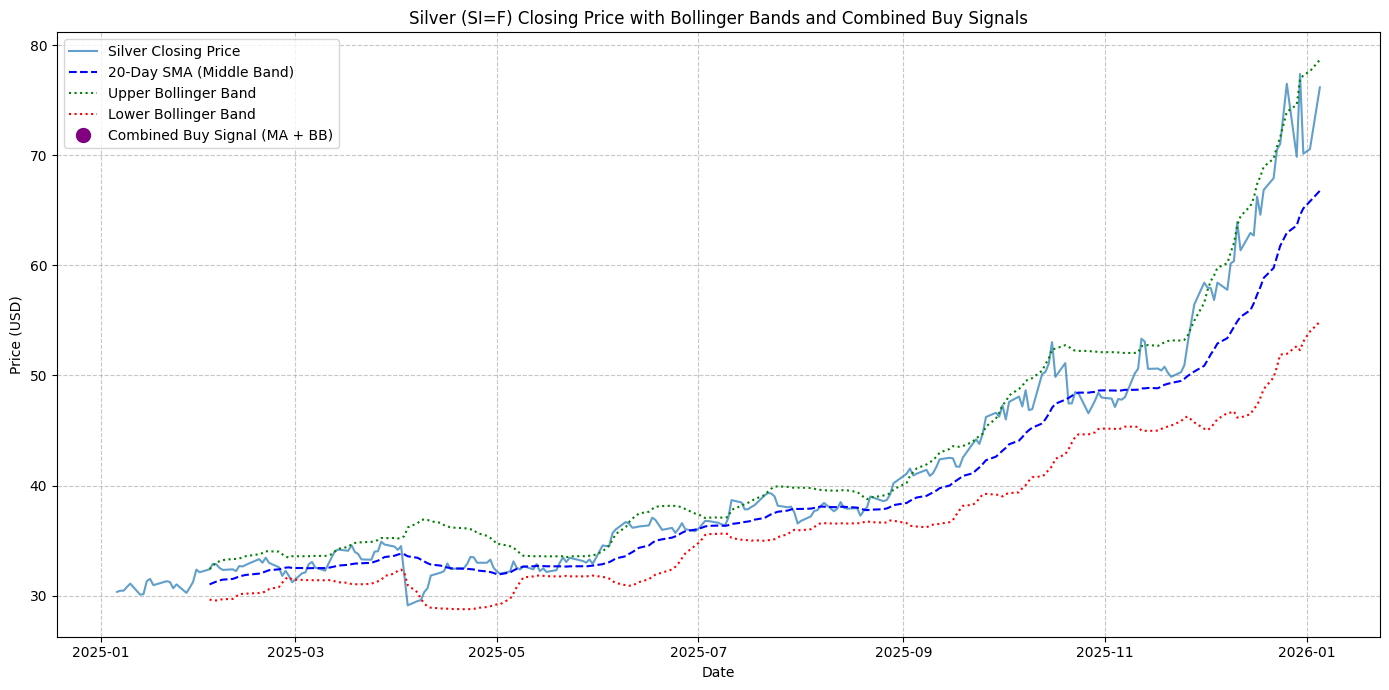

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure SMAs and Bollinger Bands are calculated
if 'SMA50' not in historical_prices.columns:
    historical_prices['SMA50'] = historical_prices['Close'].rolling(window=50).mean()
    historical_prices['SMA200'] = historical_prices['Close'].rolling(window=200).mean()

    historical_prices.loc[historical_prices.index[50:], 'Signal'] = np.where(historical_prices['SMA50'][50:] > historical_prices['SMA200'][50:], 1, -1)
    historical_prices['Position'] = historical_prices['Signal'].diff()

if 'SMA_BB' not in historical_prices.columns:
    window = 20
    num_of_std_dev = 2
    historical_prices['SMA_BB'] = historical_prices['Close'].rolling(window=window).mean()
    historical_prices['STD_DEV'] = historical_prices['Close'].rolling(window=window).std()
    historical_prices['Upper_Band'] = historical_prices['SMA_BB'] + (historical_prices['STD_DEV'] * num_of_std_dev)
    historical_prices['Lower_Band'] = historical_prices['SMA_BB'] - (historical_prices['STD_DEV'] * num_of_std_dev)

# Identify MA buy signals (golden cross)
ma_buy_signals = historical_prices[historical_prices['Position'] == 2]

# Combine with lower Bollinger Band condition
# A strong buy signal could be when MA buy signal occurs AND price is near or below lower BB
combined_buy_signals = ma_buy_signals[(ma_buy_signals['Close'] <= ma_buy_signals['Lower_Band'])]

print("Combined Buy Signal Dates (MA Golden Cross + Price at/below Lower Bollinger Band):")
for date in combined_buy_signals.index:
    print(date.strftime('%Y-%m-%d'))

# Plotting Combined Signals on Bollinger Band Chart
plt.figure(figsize=(14, 7))
plt.plot(historical_prices.index, historical_prices['Close'], label='Silver Closing Price', alpha=0.7)
plt.plot(historical_prices.index, historical_prices['SMA_BB'], label='20-Day SMA (Middle Band)', color='blue', linestyle='--')
plt.plot(historical_prices.index, historical_prices['Upper_Band'], label='Upper Bollinger Band', color='green', linestyle=':')
plt.plot(historical_prices.index, historical_prices['Lower_Band'], label='Lower Bollinger Band', color='red', linestyle=':')

# Plot the combined buy signals
plt.plot(combined_buy_signals.index,
         combined_buy_signals['Close'],
         'o', markersize=10, color='purple', lw=0, label='Combined Buy Signal (MA + BB)')

plt.title('Silver (SI=F) Closing Price with Bollinger Bands and Combined Buy Signals')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Identify buy signals (where Position changes from -1 to 1, resulting in a diff of 2)
buy_signals = historical_prices[historical_prices['Position'] == 2]
print("Buy Signal Dates:")
for date in buy_signals.index:
    print(date.strftime('%Y-%m-%d'))

print("\nSell Signal Dates:")
# Identify sell signals (where Position changes from 1 to -1, resulting in a diff of -2)
sell_signals = historical_prices[historical_prices['Position'] == -2]
for date in sell_signals.index:
    print(date.strftime('%Y-%m-%d'))

Buy Signal Dates:
2025-10-20

Sell Signal Dates:


In [18]:
display(historical_prices.describe())

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA50,SMA200,Signal,Position,SMA_BB,STD_DEV,Upper_Band,Lower_Band
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.0,252.0,203.000000,53.000000,252.000000,251.000000,233.000000,233.000000,233.000000,233.000000
mean,40.426353,40.857198,40.054746,40.470925,1766.992063,0.0,0.0,38.922476,38.869917,-0.380952,0.003984,39.663023,1.553855,42.770732,36.555313
std,10.317763,10.707656,9.998599,10.344612,10035.374065,0.0,0.0,6.772386,1.845406,0.811836,0.141365,8.416948,1.218596,10.602862,6.414762
min,28.450001,30.195000,28.309999,29.115999,0.000000,0.0,0.0,32.087620,36.217515,-1.000000,-1.000000,31.024400,0.360916,32.405174,28.765064
25%,32.887500,32.997500,32.646251,32.886001,51.750000,0.0,0.0,32.800300,37.317080,-1.000000,0.000000,32.703550,0.752064,34.880366,31.398719
50%,36.731501,36.889999,36.595999,36.779501,153.500000,0.0,0.0,37.006900,38.535455,-1.000000,0.000000,37.050450,1.224092,38.770799,35.576634
75%,46.943751,47.311249,46.427501,46.871999,394.000000,0.0,0.0,43.450560,40.250225,0.000000,0.000000,45.254800,1.864049,49.751471,40.758129
max,79.699997,79.699997,73.735001,77.374001,129966.000000,0.0,0.0,57.205180,42.632655,1.000000,2.000000,66.767101,6.132901,78.661099,54.873102


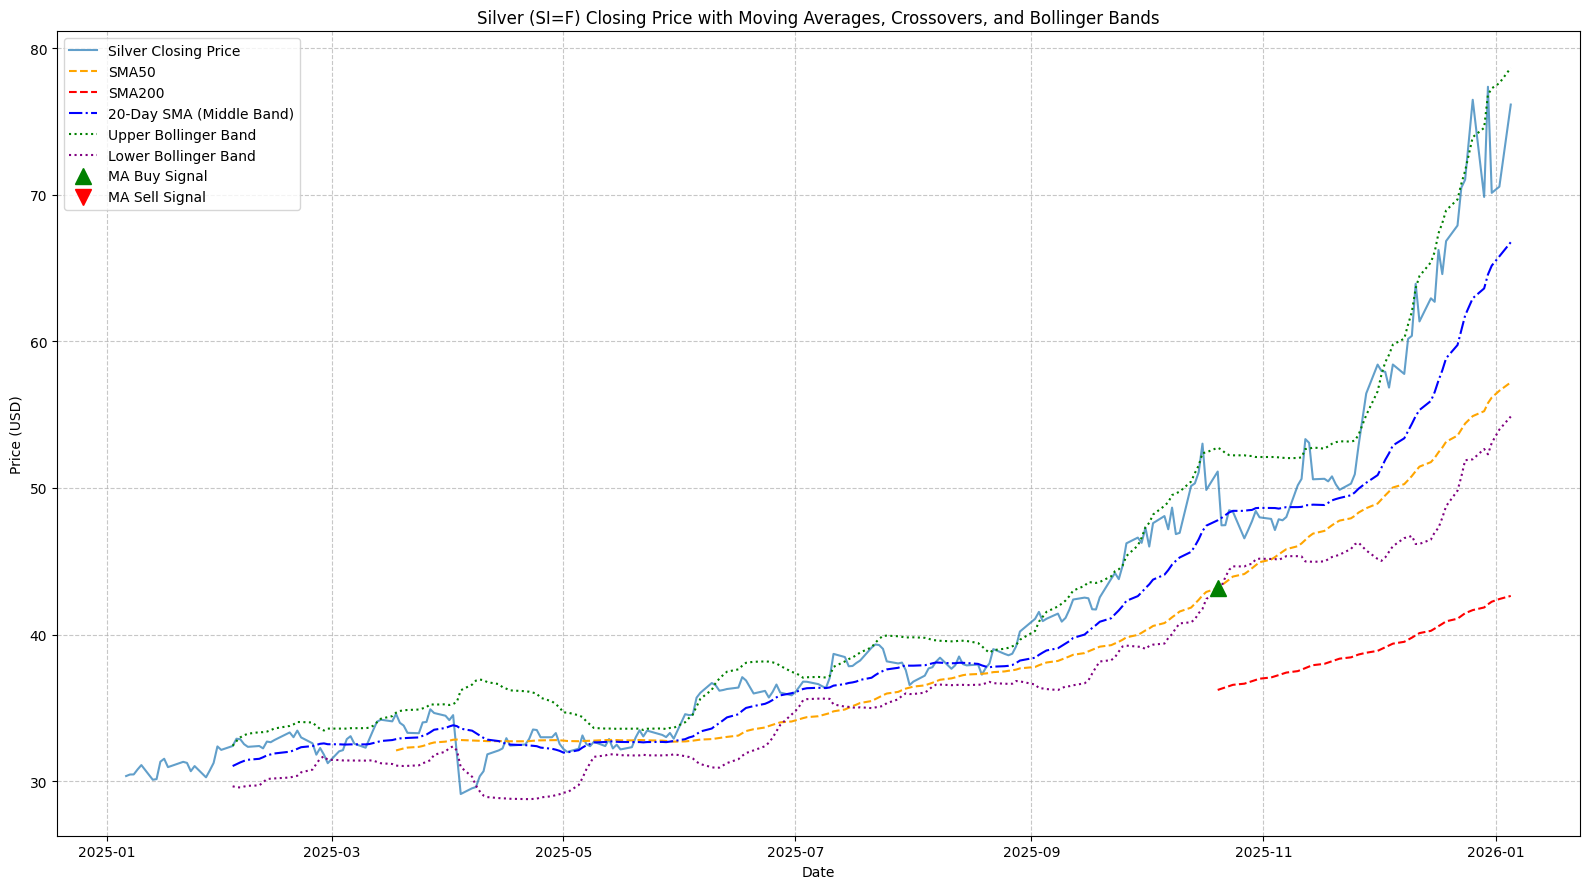

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure all necessary indicators are calculated
# Moving Averages and Crossover Signals
if 'SMA50' not in historical_prices.columns:
    historical_prices['SMA50'] = historical_prices['Close'].rolling(window=50).mean()
    historical_prices['SMA200'] = historical_prices['Close'].rolling(window=200).mean()
    historical_prices.loc[historical_prices.index[50:], 'Signal'] = np.where(historical_prices['SMA50'][50:] > historical_prices['SMA200'][50:], 1, -1)
    historical_prices['Position'] = historical_prices['Signal'].diff()

# Bollinger Bands
if 'SMA_BB' not in historical_prices.columns:
    window = 20
    num_of_std_dev = 2
    historical_prices['SMA_BB'] = historical_prices['Close'].rolling(window=window).mean()
    historical_prices['STD_DEV'] = historical_prices['Close'].rolling(window=window).std()
    historical_prices['Upper_Band'] = historical_prices['SMA_BB'] + (historical_prices['STD_DEV'] * num_of_std_dev)
    historical_prices['Lower_Band'] = historical_prices['SMA_BB'] - (historical_prices['STD_DEV'] * num_of_std_dev)

# Plotting
plt.figure(figsize=(16, 9))
plt.plot(historical_prices.index, historical_prices['Close'], label='Silver Closing Price', alpha=0.7)

# Plot Moving Averages
plt.plot(historical_prices.index, historical_prices['SMA50'], label='SMA50', color='orange', linestyle='--')
plt.plot(historical_prices.index, historical_prices['SMA200'], label='SMA200', color='red', linestyle='--')

# Plot Bollinger Bands
plt.plot(historical_prices.index, historical_prices['SMA_BB'], label='20-Day SMA (Middle Band)', color='blue', linestyle='-.')
plt.plot(historical_prices.index, historical_prices['Upper_Band'], label='Upper Bollinger Band', color='green', linestyle=':')
plt.plot(historical_prices.index, historical_prices['Lower_Band'], label='Lower Bollinger Band', color='purple', linestyle=':')

# Plot buy signals (golden cross: SMA50 crosses above SMA200)
plt.plot(historical_prices[historical_prices['Position'] == 2].index,
         historical_prices['SMA50'][historical_prices['Position'] == 2],
         '^', markersize=12, color='green', lw=0, label='MA Buy Signal')

# Plot sell signals (death cross: SMA50 crosses below SMA200)
plt.plot(historical_prices[historical_prices['Position'] == -2].index,
         historical_prices['SMA50'][historical_prices['Position'] == -2],
         'v', markersize=12, color='red', lw=0, label='MA Sell Signal')

plt.title('Silver (SI=F) Closing Price with Moving Averages, Crossovers, and Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

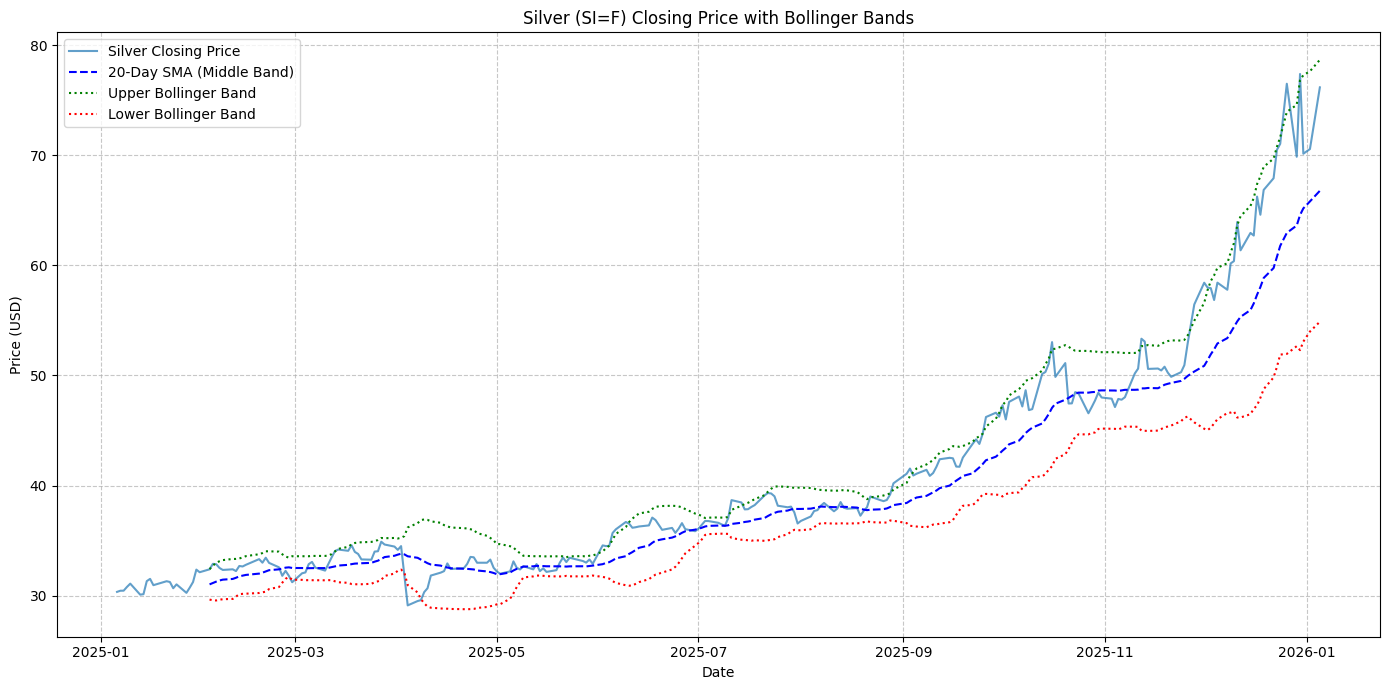

In [10]:
import matplotlib.pyplot as plt

# Calculate Bollinger Bands
window = 20
num_of_std_dev = 2

historical_prices['SMA_BB'] = historical_prices['Close'].rolling(window=window).mean()
historical_prices['STD_DEV'] = historical_prices['Close'].rolling(window=window).std()
historical_prices['Upper_Band'] = historical_prices['SMA_BB'] + (historical_prices['STD_DEV'] * num_of_std_dev)
historical_prices['Lower_Band'] = historical_prices['SMA_BB'] - (historical_prices['STD_DEV'] * num_of_std_dev)

# Plotting Bollinger Bands
plt.figure(figsize=(14, 7))
plt.plot(historical_prices.index, historical_prices['Close'], label='Silver Closing Price', alpha=0.7)
plt.plot(historical_prices.index, historical_prices['SMA_BB'], label='20-Day SMA (Middle Band)', color='blue', linestyle='--')
plt.plot(historical_prices.index, historical_prices['Upper_Band'], label='Upper Bollinger Band', color='green', linestyle=':')
plt.plot(historical_prices.index, historical_prices['Lower_Band'], label='Lower Bollinger Band', color='red', linestyle=':')

plt.title('Silver (SI=F) Closing Price with Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
!pip install yfinance

In [2]:
pip install polygon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 3.9 MB/s eta 0:00:00


Recent Silver Data with Indicators:


/tmp/ipython-input-268228555.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("SI=F", period="2y", progress=False) # Changed ticker from XAG= to SI=F
/tmp/ipython-input-268228555.py:53: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['Position'] = df['Signal'].replace(to_replace=0, method='ffill').fillna(0)


Price,Open,High,Low,Close,Volume,SMA50,SMA200,MiddleBand,BB_Std,UpperBand,LowerBand,Signal,Position
Date,,,,,,,,,,,,,
2025-12-19,66.495003,66.845001,66.485001,66.845001,144,53.15286,40.899210,58.84935,5.045925,68.941200,48.757501,0,1
2025-12-22,67.004997,68.864998,67.004997,67.905998,130,53.57222,41.077365,59.75100,4.968079,69.687158,49.814842,0,1
2025-12-23,69.080002,70.574997,69.074997,70.485001,40,53.97932,41.265350,60.76050,4.996711,70.753923,50.767077,0,1
2025-12-24,71.514999,71.514999,71.000000,71.030998,35,54.39366,41.453085,61.76535,4.936992,71.639334,51.891366,0,1
2025-12-26,74.500000,78.839996,73.735001,76.486000,140,54.90192,41.665260,62.94385,5.495037,73.933924,51.953776,0,1
2025-12-29,79.699997,79.699997,69.856003,69.856003,1608,55.23858,41.843605,63.61435,5.478559,74.571468,52.657232,0,1
2025-12-30,71.330002,77.410004,70.500000,77.374001,992,55.78878,42.060105,64.56215,6.132901,76.827952,52.296349,0,1
2025-12-31,74.605003,74.625000,70.134003,70.134003,343,56.16908,42.237880,65.16970,6.048118,77.265937,53.073464,0,1
2026-01-02,71.375000,73.589996,70.556000,70.556000,343,56.63120,42.420785,65.80145,5.909410,77.620270,53.982630,0,1


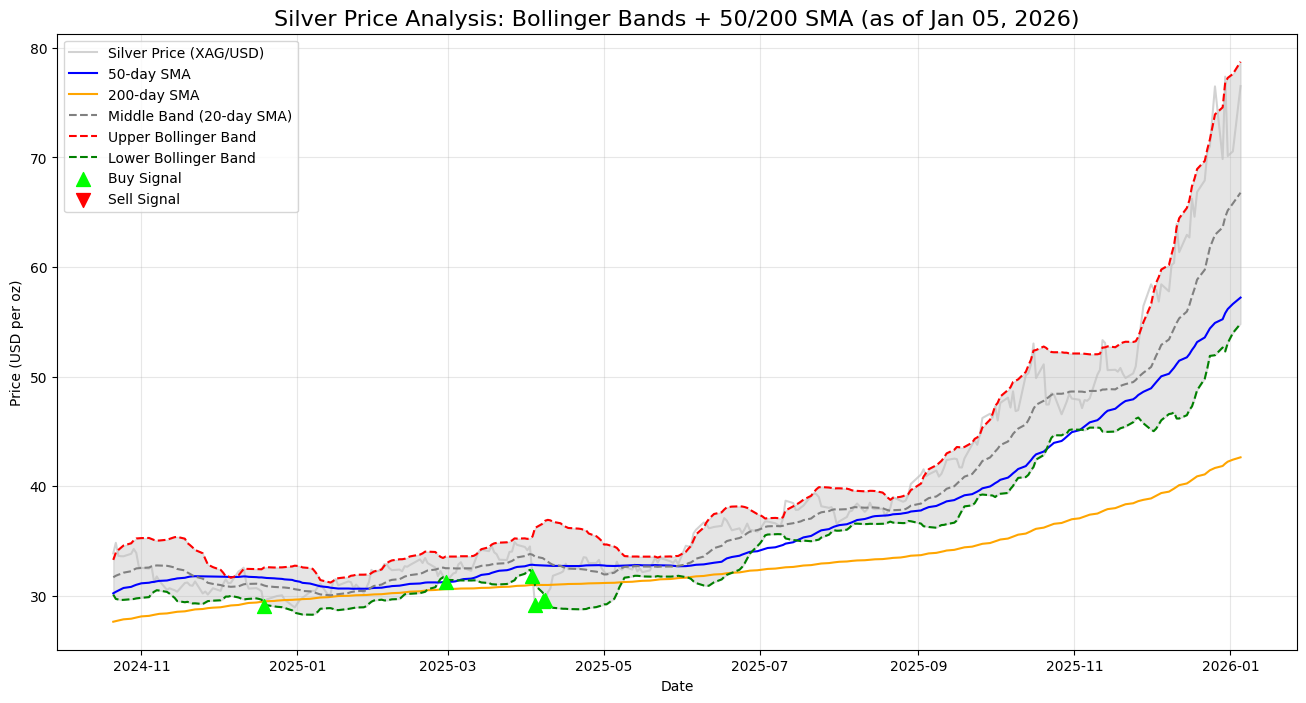


Current Silver Price: $76.51
50-day SMA: $57.21
200-day SMA: $42.63
Trend Bias: Bullish (Golden Cross)


/tmp/ipython-input-268228555.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"\nCurrent Silver Price: ${df['Close'][-1]:.2f}")
/tmp/ipython-input-268228555.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"50-day SMA: ${df['SMA50'][-1]:.2f}")
/tmp/ipython-input-268228555.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"200-day SMA: ${df['SMA200'][-1]:.2f}")
/tmp/ipython-input-268228555.py:86: Futur

In [24]:
# Single-Cell yfinance Version: Silver Bollinger Bands + Moving Averages Analysis
# As of January 05, 2026 – Fully runnable in Jupyter/Colab (no API key needed)

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fetch recent silver spot price data (XAG= is the Yahoo Finance ticker for silver in USD)
# Adjust period as needed: "1y", "2y", "5y", or "max"
df = yf.download("SI=F", period="2y", progress=False) # Changed ticker from XAG= to SI=F

# Flatten MultiIndex columns if present (common with yfinance output)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1) # Assuming the second level is redundant (e.g., ticker symbol)

# Use Adjusted Close if available, otherwise Close
df = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# Calculate Moving Averages
df['SMA50'] = df['Close'].rolling(window=50).mean()
df['SMA200'] = df['Close'].rolling(window=200).mean()

# Calculate Bollinger Bands (20-period SMA, 2 standard deviations)
period = 20
std_mult = 2
df['MiddleBand'] = df['Close'].rolling(window=period).mean()
df['BB_Std'] = df['Close'].rolling(window=period).std()
df['UpperBand'] = df['MiddleBand'] + (df['BB_Std'] * std_mult)
df['LowerBand'] = df['MiddleBand'] - (df['BB_Std'] * std_mult)

df.dropna(inplace=True) # Drop NaNs after all rolling calculations

# Generate basic trading signals
# Initialize Signal column with 0
df['Signal'] = 0

# Explicitly align the series for the conditions to prevent misalignment errors
aligned_close, aligned_lowerband = df['Close'].align(df['LowerBand'], join='inner', axis=0)
aligned_sma50, aligned_sma200 = df['SMA50'].align(df['SMA200'], join='inner', axis=0)

# Buy: Price touches/crosses below Lower Band AND in uptrend (SMA50 > SMA200)
buy_condition = (aligned_close <= aligned_lowerband) & (aligned_sma50 > aligned_sma200)
df.loc[buy_condition.index[buy_condition], 'Signal'] = 1

# Sell: Price touches/crosses above Upper Band AND in downtrend (SMA50 < 200)
aligned_close_sell, aligned_upperband = df['Close'].align(df['UpperBand'], join='inner', axis=0)
aligned_sma50_sell, aligned_sma200_sell = df['SMA50'].align(df['SMA200'], join='inner', axis=0)
sell_condition = (aligned_close_sell >= aligned_upperband) & (aligned_sma50_sell < aligned_sma200_sell)
df.loc[sell_condition.index[sell_condition], 'Signal'] = -1

# Optional: Position column (holds signal until opposite)
df['Position'] = df['Signal'].replace(to_replace=0, method='ffill').fillna(0)

# Display recent data with indicators
print("Recent Silver Data with Indicators:")
display(df.tail(10))

# Plotting
plt.figure(figsize=(16, 8))
plt.plot(df['Close'], label='Silver Price (XAG/USD)', color='silver', alpha=0.7)
plt.plot(df['SMA50'], label='50-day SMA', color='blue')
plt.plot(df['SMA200'], label='200-day SMA', color='orange')
plt.plot(df['MiddleBand'], label='Middle Band (20-day SMA)', color='gray', linestyle='--')
plt.plot(df['UpperBand'], label='Upper Bollinger Band', color='red', linestyle='--')
plt.plot(df['LowerBand'], label='Lower Bollinger Band', color='green', linestyle='--')
plt.fill_between(df.index, df['UpperBand'], df['LowerBand'], color='gray', alpha=0.2)

# Mark signals
buy_signals = df[df['Signal'] == 1]
sell_signals = df[df['Signal'] == -1]
plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='lime', s=100, label='Buy Signal', zorder=5)
plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', s=100, label='Sell Signal', zorder=5)

plt.title('Silver Price Analysis: Bollinger Bands + 50/200 SMA (as of Jan 05, 2026)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (USD per oz)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Summary stats
print(f"\nCurrent Silver Price: ${df['Close'][-1]:.2f}")
print(f"50-day SMA: ${df['SMA50'][-1]:.2f}")
print(f"200-day SMA: ${df['SMA200'][-1]:.2f}")
print(f"Trend Bias: {'Bullish (Golden Cross)' if df['SMA50'][-1] > df['SMA200'][-1] else 'Bearish (Death Cross)'}")